# Libraries Used

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
class VAE:
    def __init__(self, input_dim, hidden_dims, latent_dim):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim

        # Encoder weights and biases
        self.encoder_weights = []
        self.encoder_biases = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            # self.encoder_weights.append(np.random.randn(prev_dim, h_dim) * 0.01)
            self.encoder_weights.append(np.full(shape=(prev_dim,h_dim),fill_value=-0.5))
            self.encoder_biases.append(np.zeros((1, h_dim)))
            prev_dim = h_dim
        
        # Latent space parameters
        # self.W_mu = np.random.randn(prev_dim, latent_dim) * 0.01
        self.W_mu = np.full(shape=(prev_dim,latent_dim),fill_value=-0.5)
        self.b_mu = np.zeros((1, latent_dim))
        # self.W_logvar = np.random.randn(prev_dim, latent_dim) * 0.01
        self.W_logvar = np.full(shape=(prev_dim,latent_dim),fill_value=-0.5)
        self.b_logvar = np.zeros((1, latent_dim))

        # Decoder weights and biases
        self.decoder_weights = []
        self.decoder_biases = []
        hidden_dims_reverse = list(reversed(hidden_dims))
        prev_dim = latent_dim
        for h_dim in hidden_dims_reverse:
            # self.decoder_weights.append(np.random.randn(prev_dim, h_dim) * 0.01)
            self.decoder_weights.append(np.full(shape=(prev_dim,h_dim),fill_value=-0.5))
            self.decoder_biases.append(np.zeros((1, h_dim)))
            prev_dim = h_dim

        # Final decoder layer
        self.W_out = np.random.randn(prev_dim, input_dim) * 0.01
        self.b_out = np.zeros((1, input_dim))

    # Activation functions
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self,x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self,x):
        return np.maximum(0, x)

    def relu_derivative(self,x):
        return (x > 0).astype(float)
    
    # Loss functions
    def binary_cross_entropy(self,y_pred, y_true):
        return -np.sum(y_true * np.log(y_pred ) + (1 - y_true) * np.log(1 - y_pred))

    def binary_cross_entropy_derivative(self,y_pred, y_true):
        return (y_pred - y_true) / (y_pred * (1 - y_pred))

    def kl_divergence(self,mu, logvar):
        return -0.5 * np.sum(1 + logvar - np.square(mu) - np.exp(logvar))

    # Reparameterization trick
    def reparameterize(self,mu, logvar):
        std = np.exp(0.5 * logvar)
        eps = np.random.randn(*mu.shape)
        return mu + eps * std

    def forward(self, x):
        # Encoder forward pass
        h = x
        encoder_activations = []
        for W, b in zip(self.encoder_weights, self.encoder_biases):
            h = self.relu(np.dot(h, W) + b)
            encoder_activations.append(h)
        if not encoder_activations:
            encoder_activations.append(h)
        
        # Latent space
        mu = np.dot(h, self.W_mu) + self.b_mu
        logvar = np.dot(h, self.W_logvar) + self.b_logvar
        z = self.reparameterize(mu, logvar)
        
        # Decoder forward pass
        h = z
        decoder_activations = []
        # print(self.decoder_weights, self.decoder_biases)
        for W, b in zip(self.decoder_weights, self.decoder_biases):
            h = self.relu(np.dot(h, W) + b)
            decoder_activations.append(h)
        if not decoder_activations:
            decoder_activations.append(h)
        x_recon = self.sigmoid(np.dot(h, self.W_out) + self.b_out)

        return x_recon, mu, logvar, z, encoder_activations, decoder_activations
    
    def backward(self, x, x_recon, mu, logvar, z, encoder_activations, decoder_activations, learning_rate):
        # Compute decoder gradients
        d_x_recon = self.binary_cross_entropy_derivative(x_recon, x)
        d_h = x_recon - x

        # Update final decoder layer
        self.W_out -= learning_rate * np.dot(decoder_activations[-1].T, d_h)
        self.b_out -= learning_rate * np.sum(d_h, axis=1, keepdims=True)

        d_h = d_h = np.dot(d_h, self.W_out.T) 

        # Update decoder hidden layers
        for i in reversed(range(len(self.decoder_weights))):
            self.decoder_weights[i] -= learning_rate * np.dot(decoder_activations[i - 1].T, d_h) if i > 0 else learning_rate * np.dot(z.T, d_h)
            self.decoder_biases[i] -= learning_rate * np.sum(d_h, axis=1, keepdims=True)
            d_h = np.dot(d_h, self.decoder_weights[i].T) * self.relu_derivative(decoder_activations[i-1]) if i>0 else np.dot(d_h, self.decoder_weights[i].T)

        # Gradients for latent space
        self.W_mu -= learning_rate * (np.dot(encoder_activations[-1].T, d_h) + np.dot(encoder_activations[-1].T, mu))
        self.b_mu -= learning_rate * (np.sum(d_h, axis=1, keepdims=True) + mu)

        self.W_logvar -= learning_rate * (0.5 * d_h * np.exp(0.5 * logvar))
        self.b_logvar -= learning_rate * (np.sum(0.5 * d_h * np.exp(0.5 * logvar), axis=1, keepdims=True))

        d_mu = d_h + mu
        d_logvar = 0.5 * d_h * np.exp(0.5 * logvar)

        # Update encoder layers
        d_h = np.dot(d_mu, self.W_mu.T) + np.dot(d_logvar, self.W_logvar.T)
        for i in reversed(range(len(self.encoder_weights))):
            self.encoder_weights[i] -= learning_rate * np.dot(encoder_activations[i - 1].T, d_h) if i > 0 else learning_rate * np.dot(x.T, d_h)
            self.encoder_biases[i] -= learning_rate * np.sum(d_h, axis=0, keepdims=True)
            d_h = np.dot(d_h, self.encoder_weights[i].T) * self.relu_derivative(encoder_activations[i-1]) if i>0 else np.dot(d_h, self.encoder_weights[i].T)


[0.7982390540909666, 0.7172170537353137, 0.6575858764329238, 0.6131650672559367, 0.5796347220894257, 0.5539892776853869, 0.5341184833296662, 0.518545403652688, 0.5062132642157692, 0.49635311991303727, 0.48839997285006626, 0.48193505312065155, 0.4766390510437705, 0.4722764289997836, 0.468665669216521, 0.46565923956449284, 0.46313898451281715, 0.46102694175632897, 0.4592426643253617, 0.45773284395482944, 0.45645282114591385, 0.45535859597911915, 0.4544292761578026, 0.45363414039408295, 0.4529524760430866, 0.45236700372578686, 0.45186271836267194, 0.4514295570095563, 0.4510539550350344, 0.4507258153218546, 0.45044832475735286, 0.45020261689941066, 0.4499911461593409, 0.4498058923584431, 0.44964792380719204, 0.44950879985474806, 0.4493874131664436, 0.44928538434029663, 0.44919294620394534, 0.44911405235109764, 0.44904112482815367, 0.4489760827702979, 0.44892291733359363, 0.4488781933602365, 0.4488372029737686, 0.44880145992006215, 0.4487700878587306, 0.4487466217123269, 0.44871970189976845

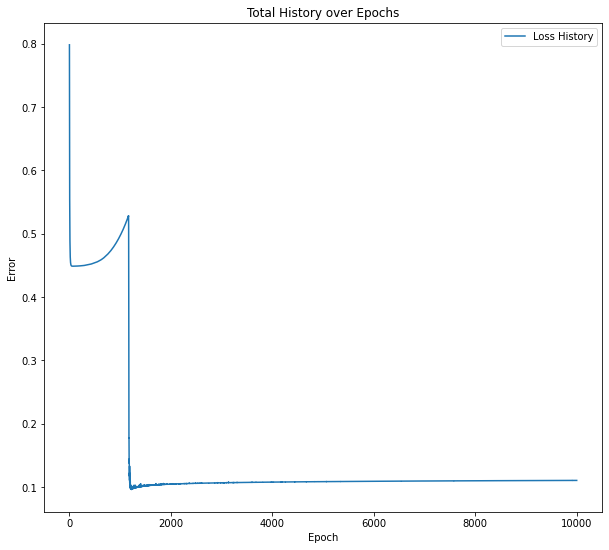

In [53]:
# Initialize the VAE with no hidden layers
input_dim = 9  # Number of input features
latent_dim = 2  # Number of latent dimensions
hidden_dims = [6,3]  

vae = VAE(input_dim=input_dim, hidden_dims=hidden_dims, latent_dim=latent_dim)

# Create your dataset
# testData = np.zeros((7,9))
# testData[0,:] = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
# testData[1,:] = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
# testData[2,:] = np.array([[1, 0, 1], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
# testData[3,:] = np.array([[1, 1, 0], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
# testData[4,:] = np.array([[1, 1, 1], [0, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
# testData[5,:] = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]).reshape(1,9).flatten()
# testData[6,:] = np.array([[1, 1, 1], [1, 0, 0], [1, 1, 1]]).reshape(1,9).flatten()
testData = np.random.choice((0,1),7*9).reshape(7,9)

data = testData  # Shape becomes (7, 9) where 7 is the number of data points
valid_data = np.zeros((1,9))
valid_data[0,:] = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]]).reshape(1, 9).flatten()

# Train the VAE
epochs = 10000
learning_rate = 0.01
history_loss = []

for epoch in range(epochs):
    total_loss = 0
    kl_loss = 0
    recon_loss = 0
    for sample in testData:  # Iterate through each column
        x = sample.reshape(1, -1)
        x_recon, mu, logvar, z, encoder_activations, decoder_activations = vae.forward(x)

        # Compute losses
        recon_loss_sample = vae.binary_cross_entropy(x_recon, valid_data)
        kl_loss_sample = vae.kl_divergence(mu, logvar)
        loss = recon_loss_sample + kl_loss_sample
        # print(f'Recon Loss:{loss}')
        # print(f'KL Loss: {kl_loss_sample}')

        # Backward pass
        vae.backward(valid_data, x_recon, mu, logvar, z, encoder_activations, decoder_activations, learning_rate)

        # Accumulate losses
        total_loss += loss
        kl_loss += kl_loss_sample
        recon_loss += recon_loss_sample

    # Loss history
    history_loss.append(loss/testData.shape[0])
    
    # Print epoch details
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{epochs} - Total Loss: {total_loss:.4f}, Recon Loss: {recon_loss:.4f}, KL Loss: {kl_loss:.4f}",end='\r')

print(history_loss)
# Evaluate: Reconstruct the input data
reconstructed = []
for x in data:
    x = x.reshape(1, -1)
    x_recon, _, _, _, _, _ = vae.forward(x)
    reconstructed.append(x_recon)
reconstructed = np.vstack(reconstructed)

print("\nOriginal Data:")
print(data)

print("\nReconstructed Data:")
print(np.round(reconstructed))  # Rounded for binary output

plt.figure(figsize=(10,9))
plt.plot(history_loss,label="Loss History")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title('Total History over Epochs')
plt.show()

In [ ]:
# Usage Example
input_dim = 784
hidden_dims = [256, 128]  # Example: 2 hidden layers with 256 and 128 units
latent_dim = 20
learning_rate = 0.001
epochs = 10
batch_size = 128

X = np.random.rand(1000, input_dim)  # Dummy data

vae = VAE(input_dim, hidden_dims, latent_dim)

for epoch in range(epochs):
    np.random.shuffle(X)
    for i in range(0, X.shape[0], batch_size):
        x_batch = X[i:i + batch_size]
        x_recon, mu, logvar, z, enc_acts, dec_acts = vae.forward(x_batch)
        loss = vae.binary_cross_entropy(x_recon, x_batch) + vae.kl_divergence(mu, logvar)
        vae.backward(x_batch, x_recon, mu, logvar, z, enc_acts, dec_acts, learning_rate)
    print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")